# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

## Original model

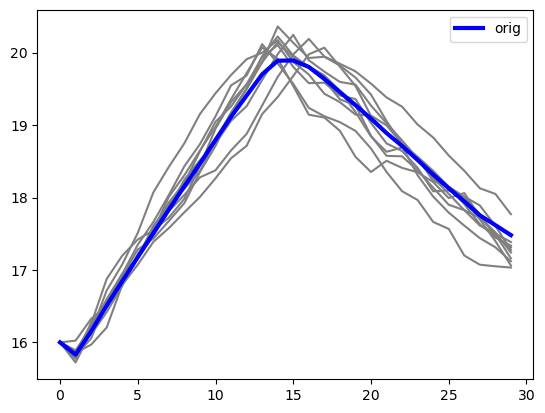

In [1]:
from cps.original_models import *

orig_params = {'T': 30,   # time steps
               'init_T': 16.,  # initial temperature
               'tOn': 17,      # turn-on temperature
               'tOff': 20}     # turn-off temperature

orig_traj = generate_traj(thermostat_model, 100, orig_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='orig')

In [2]:
#export orig_traj to csv
import pandas as pd
#consider only 20 trajectories from time 0 to 30
plot_trajectories = orig_traj[:20, 0:31]
#transpose the array so that each row is a time step and each column is a trajectory
plot_trajectories = plot_trajectories.T

df = pd.DataFrame(plot_trajectories)
df.to_csv('thermostat_orig_traj.csv', index=False)

## SOGA

In [3]:
from optimization import *
torch.set_default_dtype(torch.float64)

Loss value: tensor(2836.2401, grad_fn=<NegBackward0>)


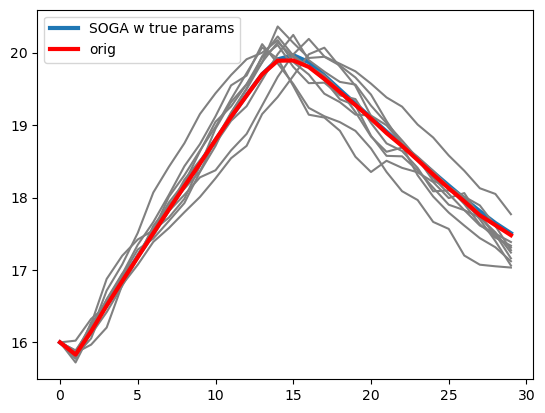

In [4]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_T = orig_params['init_T']
params = {'tOn':  17., 'tOff':20.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# computes loss
idx=list(range(1, T))
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

Loss value: tensor(8677.4820, grad_fn=<NegBackward0>)


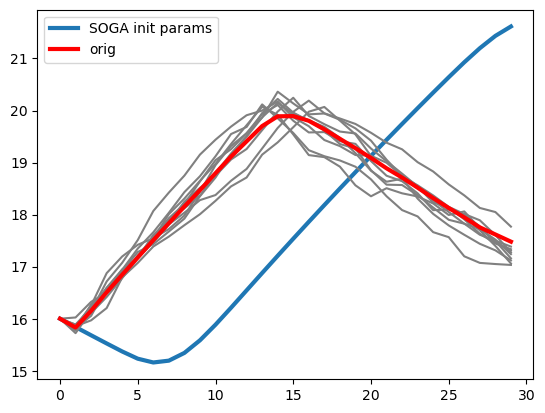

In [5]:
# we choose as initial value of the parameters values for which the loss is higher 
# and there is a significant difference in the mean trajectories

# new cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initial parameters
init_params = {'tOn':  15., 'tOff':22.}
params_dict = initialize_params(init_params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# loss
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

y = []
y_var = []
for i in range(31):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat_init.csv', index=False)

tOn: 15.099999999999728 tOff: 21.9000000000003  loss: 8677.482030033518
tOn: 15.200034475136226 tOff: 21.79998577668924  loss: 7915.427388515227
tOn: 15.300030460759256 tOff: 21.700160591126675  loss: 7142.92595153279
tOn: 15.399352427139865 tOff: 21.600707093838462  loss: 6478.840953324627
tOn: 15.497301591346062 tOff: 21.50184622240717  loss: 5893.162754841068
tOn: 15.59369830160311 tOff: 21.40381088809243  loss: 5369.3776185484085
tOn: 15.68875559499936 tOff: 21.30691657860882  loss: 4891.856375513503
tOn: 15.781759038269282 tOff: 21.211482940782624  loss: 4464.291077607357
tOn: 15.870936821323381 tOff: 21.117781456042685  loss: 4114.273138782877
tOn: 15.954308429929183 tOff: 21.026045662930294  loss: 3850.789663148
tOn: 16.030612130870125 tOff: 20.93647483144923  loss: 3658.4835324198475
tOn: 16.09968066410764 tOff: 20.84923299882226  loss: 3512.1955561658547
tOn: 16.16203990821848 tOff: 20.764462216598677  loss: 3392.2321425933924
tOn: 16.218391338499732 tOff: 20.682298751283394  

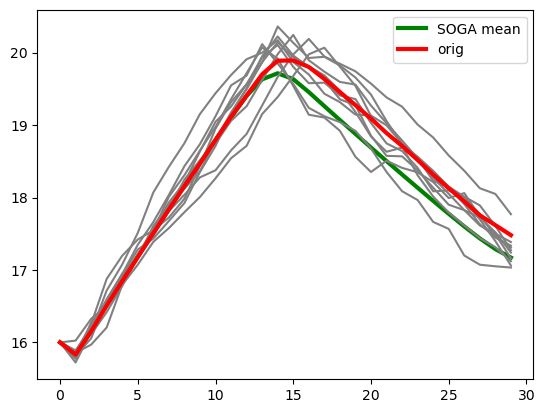

In [ ]:
# Optimization in SOGA


# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(init_params)

# Define loss
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

# cfg for SOGA
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# gradient based optimization
loss_list, time_opt, n_iters = optimize(cfg, params_dict, loss, n_steps=40, lr=0.1)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [8]:
loss_list

([8677.482030033518,
  7915.427388515227,
  7142.92595153279,
  6478.840953324627,
  5893.162754841068,
  5369.3776185484085,
  4891.856375513503,
  4464.291077607357,
  4114.273138782877,
  3850.789663148,
  3658.4835324198475,
  3512.1955561658547,
  3392.2321425933924,
  3289.3144905764,
  3200.2204582394434,
  3123.597403340822,
  3058.4668109619756,
  3003.9005611042276,
  2958.962321259268,
  2922.701962414897,
  2894.167906586579,
  2872.426863643863,
  2856.582141772841,
  2845.7848490680117,
  2839.237976914093,
  2836.1964378743482,
  2835.965739397896,
  2837.9009875687966,
  2841.4074781287154,
  2845.9435154332778,
  2851.025085966193,
  2856.2312100527615,
  2861.208605302201,
  2865.6745961471775,
  2869.4176679879356,
  2872.295481306452,
  2874.230467373979,
  2875.2033370158224,
  2875.2449701326486,
  2874.427226487101],
 54.512,
 40)

In [7]:
# export loss_list to csv
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))

df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('thermostat_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [8]:
y = []
y_var = []
for i in range(31):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat_opt.csv', index=False)

## Pyro estimation

In [23]:
from cps.pyro_models import *

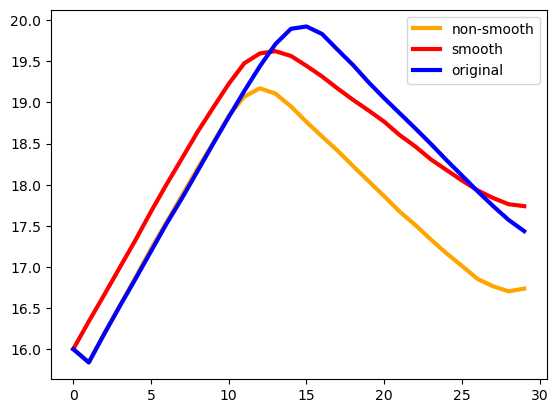

In [24]:
# this is to check that the model I am using are right for the correct parameters

def thermostat_pyro_proof(batch_size=100, k=0.01, h=0.5):

    T = 30
    init_T = 16.
    init_tOn = 17.
    init_tOff = 20.

    tOn = pyro.sample("tOn", dist.Normal(init_tOn, 1.0))
    tOff = pyro.sample("tOff", dist.Normal(init_tOff, 1.0))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn = torch.zeros(batch_size, dtype=torch.bool)
    noise = dist.Normal(0.0, 0.1)

    for i in range(1, T):
        traj[:, i] = traj[:, i - 1] - k * traj[:, i - 1] + noise.sample([batch_size])
        traj[:, i] += h * isOn.float()
        isOn = torch.where((isOn & (traj[:, i] > tOff)) | (~isOn & (traj[:, i] < tOn)), ~isOn, isOn)

    return traj

def thermostat_smooth_pyro_proof(batch_size=100, sharpness=5, k=0.01, h=0.5):
        
    T = 30
    init_T = 16.
    init_tOn = 17.
    init_tOff = 20.

    # higher sharpness means sharper transitions 
    tOn = pyro.sample("tOn", dist.Normal(init_tOn, 0.1))
    tOff = pyro.sample("tOff", dist.Normal(init_tOff, 0.1))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn_prob = torch.zeros(batch_size)  # probability that isOn is True
    noise = dist.Normal(0.0, 0.1)

    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    for i in range(1, T):
        # Smooth transitions
        turn_on =  sigmoid(sharpness * (tOn - traj[:, i-1]))
        turn_off = sigmoid(sharpness * (traj[:, i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on
        traj[:, i] = traj[:, i-1] - k * traj[:, i-1] + h * isOn_prob + noise.sample([batch_size])

    return traj

plot_traj_set(thermostat_pyro_proof(), single_traj=0, color='orange', label='non-smooth')
plot_traj_set(thermostat_smooth_pyro_proof(), single_traj=0, color='red', label='smooth')
plot_traj_set(orig_traj, single_traj=0, label='original')

### MCMC

In [25]:
### Initial parameters for optimization
init_params = {'T': 30,         # time steps
            'init_T': 16.,    # initial temperature
            'tOn': 15.,       # turn-on temperature
            'tOff': 22.}      # turn-off temperature

### creates Pyro models with the initial parameters
thermostat_pyro = create_thermostat_pyro(init_params, eps=2.0)
thermostat_smooth_pyro = create_thermostat_smooth_pyro(init_params, sharpness=5, eps=2.0)

Sample: 100%|██████████| 600/600 [19:36,  1.96s/it, step size=4.58e-17, acc. prob=0.000]


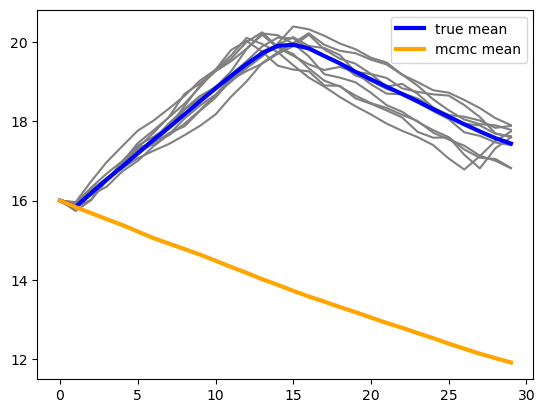

In [26]:
# Non-smooth models

### runs NUTS to get posterior samples
posterior_samples = run_NUTS(thermostat_pyro, orig_traj, num_samples=500, warmup_steps=100, num_chains=1)

### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_params = {'T': 30,
               'init_T': 16.,
               'tOn': posterior_samples['tOn'].mean().item(),
               'tOff': posterior_samples['tOff'].mean().item()}


mcmc_traj = generate_traj(thermostat_model, 100, mcmc_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

Sample: 100%|██████████| 1000/1000 [1:33:19,  5.60s/it, step size=6.53e-42, acc. prob=0.000]


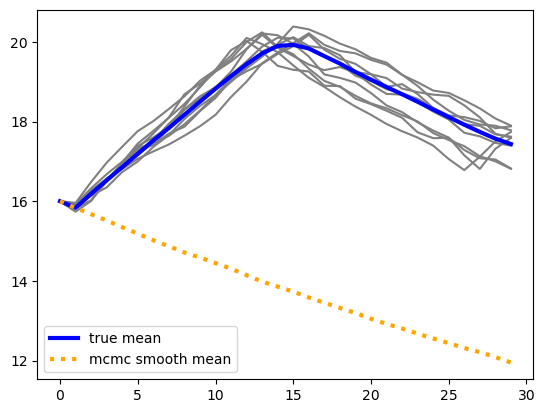

In [27]:
# Smooth model

### runs NUTS to get posterior samples
posterior_samples_smooth = run_NUTS(thermostat_smooth_pyro, orig_traj[:10], num_samples=500, num_chains=1)

### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_smooth_params = {'T': 30,
                      'init_T': 16.,
                      'tOn': posterior_samples_smooth['tOn'].mean().item(),
                      'tOff': posterior_samples_smooth['tOff'].mean().item()}


mcmc_smooth_traj = generate_traj(thermostat_model, 100, mcmc_smooth_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_smooth_traj, single_traj=0, color='orange', ls=':', label='mcmc smooth mean')

### VI Optimization

In [28]:
from cps.pyro_models import *

In [29]:
### Initial parameters for optimization
init_params = {'T': 30,         # time steps
            'init_T': 16.,    # initial temperature
            'tOn': 15.,       # turn-on temperature
            'tOff': 22.}      # turn-off temperature

### creates Pyro models with the initial parameters
thermostat_pyro = create_thermostat_pyro(init_params, eps=2.0)
thermostat_smooth_pyro = create_thermostat_smooth_pyro(init_params, sharpness=5, eps=1.0)

Step 0: Loss = 7224.869373199394
Step 100: Loss = 6307.512699241781
Step 200: Loss = 7177.668654922925
Step 300: Loss = 6757.792904760866
Step 400: Loss = 7282.531746663405
Step 500: Loss = 8216.441957668028
Step 600: Loss = 6781.413283676379
Step 700: Loss = 7069.424423672355
Step 800: Loss = 7200.333905073524
Step 900: Loss = 6836.086224284312
Step 1000: Loss = 7068.557184198002
Step 1100: Loss = 6953.056614248213
Step 1200: Loss = 6910.091934641128
Step 1300: Loss = 10249.958871075392
Step 1400: Loss = 7078.7879503301565
Step 1500: Loss = 6740.677165345086
Step 1600: Loss = 6493.671692023915
Step 1700: Loss = 6931.19424837423
Step 1800: Loss = 6833.515067716843
Step 1900: Loss = 7074.97827310411
Optimization performed in 6.96 seconds
Optimized tOn: 15.072083031957924, tOff: 21.89124088936885


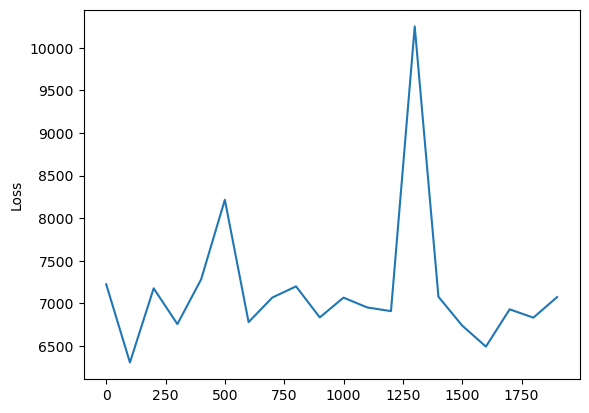

In [36]:
# Non-smooth model

### creates guide
thermostat_guide = create_thermostat_guide(init_params)

### runs SVI to get optimized parameters
run_SVI(thermostat_pyro, thermostat_guide, orig_traj,num_steps = 2000, lr=0.1, num_particles=1, loss_plot=True)

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

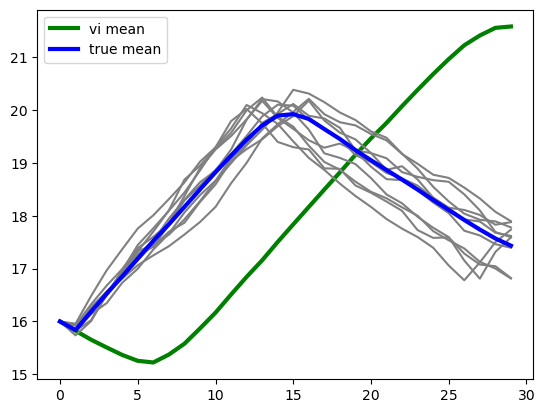

In [37]:
# plot

vi_traj = generate_traj(thermostat_model, 100, {'T': 30, 
                                               'init_T': 16., 
                                               'tOn': vi_tOn, 
                                               'tOff': vi_tOff})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

Step 0: Loss = 9898.386167704517
Step 100: Loss = 4370.287017884529
Step 200: Loss = 3681.5228707877673
Step 300: Loss = 5316.411165461926
Step 400: Loss = 3636.6722400378276
Step 500: Loss = 3716.7619520262665
Step 600: Loss = 4585.128134334955
Step 700: Loss = 3719.697133183415
Step 800: Loss = 3933.160913718985
Step 900: Loss = 5628.910872456182
Optimization performed in 6.17 seconds
Optimized tOn: 17.249304261582296, tOff: 20.002928195422705


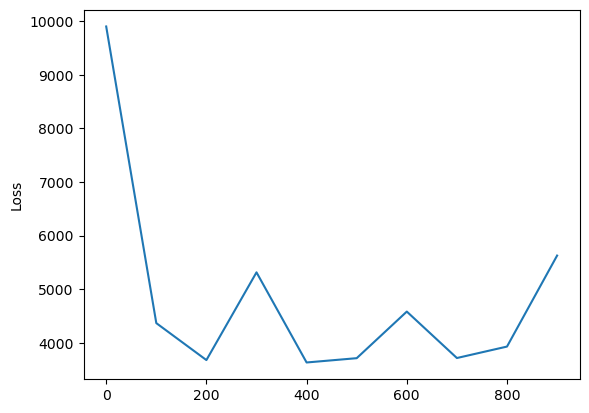

In [32]:
# Smooth model

### creates guide
thermostat_guide = create_thermostat_guide(init_params)

### runs SVI to get optimized parameters
run_SVI(thermostat_smooth_pyro, thermostat_guide, orig_traj, num_particles=1, loss_plot=True)

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

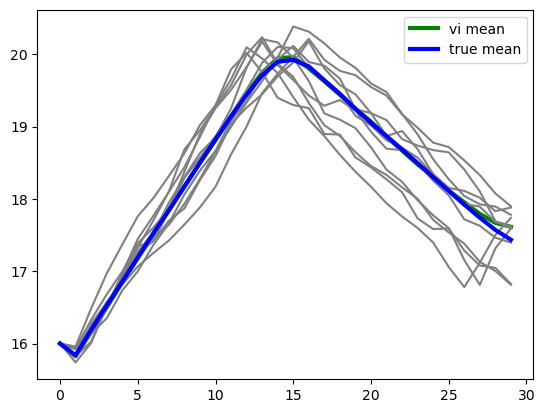

In [33]:
# plot

vi_traj = generate_traj(thermostat_model, 100, {'T': 30, 
                                               'init_T': 16., 
                                               'tOn': vi_tOn, 
                                               'tOff': vi_tOff})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

## Analysis of gradient behaviour

In [34]:
# original model without noise
def det_orig_model(T=10, init_T=17., tOn=16, tOff=20, k=0.01, h=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj    


# model smoothed with sigmoid (for pyro)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def smooth_orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.1, sharpness=1.):
    
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    traj = torch.zeros(T)
    isOn = 0.
    traj[0] = init_T
        
    for i in range(1,T):
        
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn = isOn * (1 - turn_off) + (1 - isOn) * turn_on

        traj[i] = traj[i-1] -k*traj[i-1] + h * isOn + noise.sample()
            
    return traj    

In [35]:
# without noise the model is discontinuous 

import numpy as np
import matplotlib.pyplot as plt


# does it make sense to use this? 
def loss_for_params(model, tOn, tOff, batch_size):
    # Use the original model to generate trajectories with fixed tOn, tOff
    # and compute negative log likelihood on the observed data
    trajs = []
    for _ in range(batch_size):  # use a small batch for speed
        trajs.append(model(tOn=tOn, tOff=tOff))
    trajs = torch.vstack(trajs)
    # Negative log likelihood under the observed data
    # (use the same likelihood as in your SVI)
    with torch.no_grad():
        loss = 0
        for i in range(orig_traj.shape[0]):
            loss += -torch.distributions.Normal(trajs.mean(0), 0.5).log_prob(orig_traj[i]).sum()
        loss /= orig_traj.shape[0]   # added normalization
    return loss.item()

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 200)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(det_orig_model, tOn, tOff_fixed, batch_size=1))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([30]) vs torch.Size([10]).

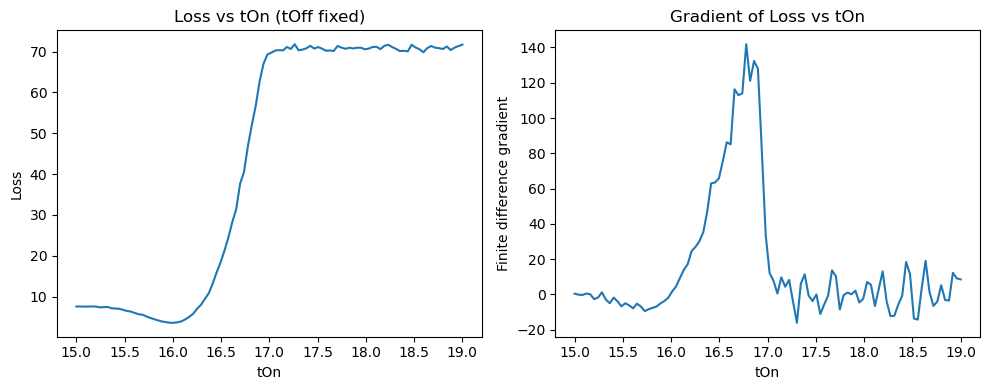

In [ ]:
# with noise the loss is continuous but the gradient oscillates a lot

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

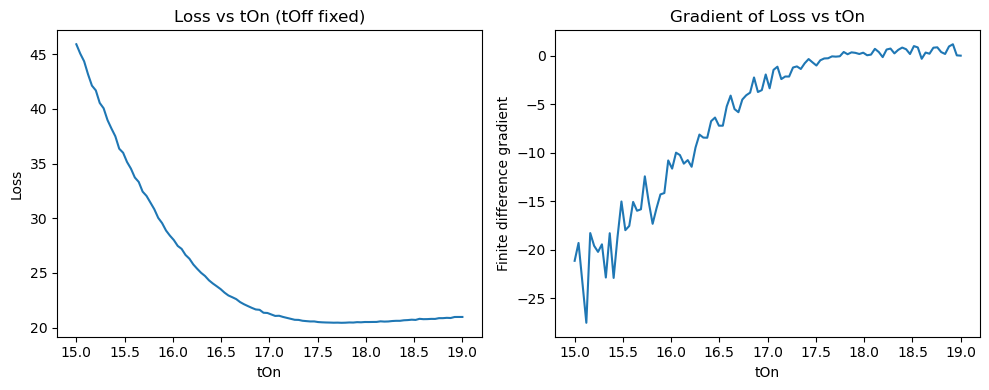

In [ ]:
# with smoothing

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(smooth_orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()